### **RGB Image Classification Capstone Project**

In [51]:
from pyasn1_modules.rfc3161 import Accuracy
from torchgen.api.ufunc import kernel_name
from webencodings import labels

''' Import all Important Libraries '''
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [52]:
torch.manual_seed(40)
Device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device :',Device)

Using Device : cpu


### **Data Pipeline**

In [53]:
Transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5))
    ])

In [54]:
class CIFAR10Dataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = datasets.CIFAR10(
            root='./data',
            train=train,
            download=True,
        )
        self.transform = transform
        self.classes = self.dataset.classes
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
            return image, label

In [55]:
Train_dataset = CIFAR10Dataset(train=True, transform=Transformation)
Test_dataset = CIFAR10Dataset(train=False, transform=Transformation)
print(len(Train_dataset))
print(len(Test_dataset))

50000
10000


In [56]:
example_image, example_label = Train_dataset[0]
print(f'image shape:{example_image.shape}\n label shape:{Train_dataset.classes[example_label]}')

image shape:torch.Size([3, 32, 32])
 label shape:frog


### **Train, Test DataLoader**

In [57]:
Train_DataLoader = DataLoader(
    dataset=Train_dataset,
    batch_size=16,
    shuffle=True
)

Test_DataLoader = DataLoader(
    dataset=Test_dataset,
    batch_size=16 ,
    shuffle=False
)

### ***Convo > Pooling > Relu > Linear > Flatten***

In [58]:
class MyImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=3,
            padding=1
        )
        self.pooling = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            padding=1
        )

        self.Linear1 = nn.Linear(128 * 8 * 8, 128)
        self.Linear2 = nn.Linear(128, 10)

    def forward(self, x):
        # First conv Layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pooling(x)

        # Second Conv Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pooling(x)

        # # Third Conv Layer
        # x =self.conv3(x)
        # x = self.relu(x)
        # x = self.pooling(x)


        # Flatten
        x = x.view(-1, 128 * 8 * 8)
        x = self.Linear1(x) # Layer 1
        x = self.relu(x)

        x = self.Linear2(x) # Layer 2


        return x

In [59]:
Model = MyImageNet().to(Device)
print(Model)

MyImageNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Linear1): Linear(in_features=8192, out_features=128, bias=True)
  (Linear2): Linear(in_features=128, out_features=10, bias=True)
)


### **Train Model**

100%|██████████| 3125/3125 [00:41<00:00, 75.49it/s]


Epoch 1/20 Loss: 1.276


100%|██████████| 3125/3125 [00:41<00:00, 75.63it/s]


Epoch 2/20 Loss: 0.926


100%|██████████| 3125/3125 [00:41<00:00, 75.61it/s]


Epoch 3/20 Loss: 0.789


100%|██████████| 3125/3125 [00:41<00:00, 75.58it/s]


Epoch 4/20 Loss: 0.689


100%|██████████| 3125/3125 [00:41<00:00, 75.43it/s]


Epoch 5/20 Loss: 0.610


100%|██████████| 3125/3125 [00:55<00:00, 56.05it/s]


Epoch 6/20 Loss: 0.539


100%|██████████| 3125/3125 [01:11<00:00, 43.49it/s]


Epoch 7/20 Loss: 0.480


100%|██████████| 3125/3125 [00:42<00:00, 74.16it/s]


Epoch 8/20 Loss: 0.426


100%|██████████| 3125/3125 [00:42<00:00, 72.81it/s]


Epoch 9/20 Loss: 0.370


100%|██████████| 3125/3125 [00:42<00:00, 72.92it/s]


Epoch 10/20 Loss: 0.327


100%|██████████| 3125/3125 [00:42<00:00, 72.79it/s]


Epoch 11/20 Loss: 0.292


100%|██████████| 3125/3125 [00:42<00:00, 72.84it/s]


Epoch 12/20 Loss: 0.257


100%|██████████| 3125/3125 [00:42<00:00, 73.03it/s]


Epoch 13/20 Loss: 0.227


100%|██████████| 3125/3125 [00:59<00:00, 52.48it/s]


Epoch 14/20 Loss: 0.200


100%|██████████| 3125/3125 [00:41<00:00, 75.78it/s]


Epoch 15/20 Loss: 0.186


100%|██████████| 3125/3125 [00:41<00:00, 75.65it/s]


Epoch 16/20 Loss: 0.171


100%|██████████| 3125/3125 [00:42<00:00, 73.29it/s]


Epoch 17/20 Loss: 0.151


100%|██████████| 3125/3125 [00:44<00:00, 70.45it/s]


Epoch 18/20 Loss: 0.146


100%|██████████| 3125/3125 [00:43<00:00, 71.47it/s]


Epoch 19/20 Loss: 0.137


100%|██████████| 3125/3125 [00:43<00:00, 72.24it/s]


Epoch 20/20 Loss: 0.132


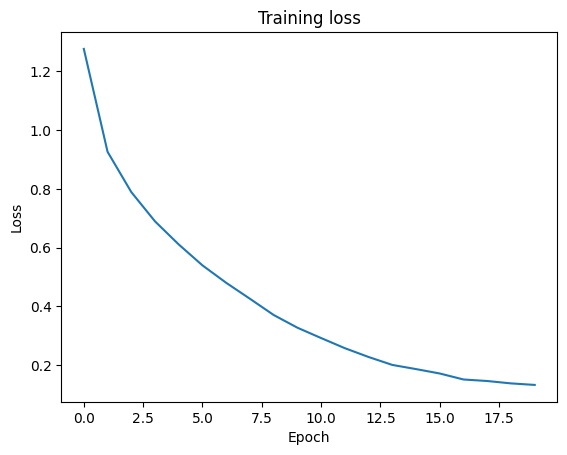

In [60]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr=0.001)
num_epochs = 20
criterion_losses = []
for epoch in range(num_epochs):
    Model.train()
    running_loss = 0.0
    Accuracy = 0.0
    batch=0


    for images, label in tqdm(Train_DataLoader):
        images, label = images.to(Device), label.to(Device)
        batch += 1
        optimizer.zero_grad()
        outputs = Model(images)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    epoch_loss = running_loss / len(Train_DataLoader)
    criterion_losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs} Loss: {epoch_loss:.3f}')

import matplotlib.pyplot as plt
plt.plot(criterion_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

### **Model Evaluation**

In [63]:
import numpy as np
Model.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, label in Test_DataLoader:
        images, label = images.to(Device), label.to(Device)
        outputs = Model(images)
        _, Predict = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (Predict == label).sum().item()
# KL Divergence

from scipy.stats import entropy
predict, _ = np.histogram(Predict, bins=50, density=True)
outputs, _ = np.histogram(outputs, bins=50, density=True)
kl_divergence = entropy(predict+1e-10, outputs+1e-10)
best_model = 0
Accuracy = 100 * correct / total
print(f'Mode Accuracy: {Accuracy:.3f}, KL Divergence: {kl_divergence:.3f}')
if Accuracy > best_model:
    best_model = Accuracy
    torch.save(Model.state_dict(), 'Best_Model.pth')


Mode Accuracy: 67.600, KL Divergence: 2.241
